# Packages

In [83]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statannotations.Annotator as statannotator
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sys

# Appending python modules so we can run simulations
sys.path.append('../python')

import json_utilities
import model_utilities
from matplotlib.pyplot import figure
from pymunk.vec2d import Vec2d
from scipy import stats

In [4]:
# Are we saving the cleaned data to a JSON?
saving_clean_data_to_dist = True
data_dir = '../data/cleaned_data'

In [5]:
# Are we saving figures?
saving_figures = False
figure_dir = '../paper/figures/src'

## Plotting parameters

In [6]:
sns.set_theme(
    style='whitegrid',
    palette='bright',
    font_scale=1.5,
    rc={
        'figure.dpi':300,
        'font.family':'sans-serif',
        'font.sans-serif':['Helvetica'],
    },
)


# Helper functions

# Importing and cleaning data

## Importing data

In [7]:
data_path_exp1 = '../experiments/experiment1/data/data.csv'

In [8]:
df_full_data_exp1 = pd.read_csv(data_path_exp1)

In [9]:
df_full_data_exp1['experiment_version'] = 1

## Demographics

In [10]:
demographics_data_path_exp1 = '../experiments/experiment1/data/demographic_data.csv'

In [11]:
df_demographic_data_exp1 = pd.read_csv(demographics_data_path_exp1)

In [12]:
df_demographic_data_exp1['experiment_version'] = 1

In [13]:
# Sex
df_demographic_data_exp1.Sex.value_counts()

Series([], Name: Sex, dtype: int64)

In [14]:
# Age
df_demographic_data_exp1[df_demographic_data_exp1['Age'] != 'CONSENT_REVOKED'].Age.astype(int).mean()

nan

## Cleaning data

### Experiment 1

Here, we're removing unused columns that contain metadata from jsPsych. These are unnecessary for our analyses.In line with good practice with dataframes, we are making a copy of our original dataframe `df_full_data_exp1` for analysis and calling it `df_exp1` 

In [39]:
# Removing unused columns from jsPsych
df_exp1 = df_full_data_exp1.drop(columns=['success', 
                                          'failed_images',
                                          'failed_audio',
                                          'failed_video',
                                          'time_elapsed',
                                          'scene_sp',
                                          'internal_node_id',
                                          'session_id',
                                          'study_id',
                                          'value',
                                          'stimulus',
                                          'timeout',
                                          'trial_type',
                                          'timed_out',
                                          'response',
                                          'correct_response',
                                          'task_condition',
                                         ]
                                )

**Cleaning responses:**

In [40]:
# Remove attempts column since we no longer are using it
df_exp1 = df_exp1.drop(columns=['attempts',
                                'condition',
                                'trial_index',
                               ]
                      )

**Cleaning scene types:** Our variable `scene_type` codes which scene type the participant is viewing (e.g. stim_2, stim_4, or stim_6). jsPsych records these data verbosely (e.g. "stim_2_goalpos_1_negative.mp4"). Here, we're cleaning up the `scene_type` entries so they just say what scene type the user viewed. For example, the entry "stim_2_goalpos_1_negative.mp4" will be changed to "stim_2".

In [41]:
# Convert all scene type entries to strings
df_exp1.scene_type = df_exp1.scene_type.astype(str)
# Retain only the scene type (remove "_goalpos_" substring)
df_exp1.scene_type = df_exp1.scene_type.apply(lambda x: '_'.join(x.split('_')[:2]))

**Cleaning scenes:** The `scene` variable codes the actual scene the participant viewed (e.g. "stim_2_goalpos_1_negative.mp4"). We want to remove the ".mp4" substring from the entries in this variable.

In [42]:
# Convert all scene entries to strings
df_exp1.scene = df_exp1.scene.astype(str)
# Retain only the scene name (remove ".mp4" substring)
df_exp1.scene = df_exp1.scene.apply(lambda x: x.split('.')[0])

**Only viewing responses:** Since we removed the participants who failed the comprehension check, we are now only interested in the remaining participants' responses. So, we're removing the data that isn't coded as "response" in the `task` variable.

In [43]:
# Remove all tasks that aren't coded as response
df_exp1 = df_exp1.loc[(df_exp1.task == 'response')]

In [44]:
# Remove the task column since we no longer are using it
df_exp1 = df_exp1.drop(columns=['task'])

**Extract sim time condition**: We're just grabbing the simulation time condition from the scene condition

In [45]:
df_exp1['simulation_time_condition'] = df_exp1.scene_type.apply(lambda x: x.split('_')[0])

**Extract path condition**: We're just grabbing the path condition from the scene

In [46]:
df_exp1['path_condition'] = df_exp1.scene.apply(lambda x: 'straight' if 'yessp' in x else 'not_straight')



**Compute z-scores:** We need to compute the z-scores of response times `rt`. We will do so participant-wise (per participant) and add them as new variable `participant_z_rt`.

In [47]:
# Calculate participant-wise z-score for response time
df_exp1['participant_z_rt'] = df_exp1.groupby(['experiment_version','subject_id']).rt.apply(lambda x: (x-x.mean()) / x.std())

**Removing outlier response times**: We can now remove outlier response times. We use the 2-SD methd as per Alexander Berger and Markus Kiefer, 2021. 2-SD outlier exclusion demonstrated best results for omitting Type-1 errors (false positives) and retaining original data.

In [48]:
# Determine number of datapoints lost by outlier exclusion
excluded = len(df_exp1) - len(df_exp1[abs(df_exp1.participant_z_rt) <= 2])
print(f'{excluded} of {len(df_exp1)} ({excluded/len(df_exp1)*100:.4}%) are excluded via 2-SD exclusion')

105 of 2256 (4.654%) are excluded via 2-SD exclusion


In [49]:
# Excluding outliers
df_exp1 = df_exp1[abs(df_exp1.participant_z_rt) <= 2]

**Clarifying variable names**: Now we rename some columns to make their values more clear.

In [50]:
df_exp1 = df_exp1.rename(columns={'scene_col': 'scene_collision_condition'})
df_exp1 = df_exp1.reset_index(drop=True)

In [51]:
# Save file locally
if saving_clean_data_to_dist:
    print('Data saved...')
    path = os.path.join(data_dir,'cleaned_data_exp1.json')
    df_exp1.to_json(path)
else:
    print('Data was not saved...')

Data saved...


In [52]:
data = pd.read_json(os.path.join(data_dir,'cleaned_data_exp1.json'))

In [53]:
num_subjects = len(set(data.subject_id))

In [54]:
new_ids = list(range(num_subjects))

In [55]:
data

,subject_id,rt,correct,scene,scene_type,scene_index,scene_collision_condition,experiment_version,simulation_time_condition,path_condition,participant_z_rt
0,61716480d6da1714ff60ed0d,884,True,low_nocol_yessp_1,low_nocol,1,no,1,low,straight,-0.789426
1,61716480d6da1714ff60ed0d,726,False,low_yescol_yessp_2,low_yescol,2,yes,1,low,straight,-0.953251
2,61716480d6da1714ff60ed0d,885,True,low_nocol_nosp_2,low_nocol,2,no,1,low,not_straight,-0.788389
3,61716480d6da1714ff60ed0d,981,True,med_nocol_nosp_3,med_nocol,3,no,1,med,not_straight,-0.688849
4,61716480d6da1714ff60ed0d,1189,True,high_yescol_yessp_2,high_yescol,2,yes,1,high,straight,-0.473180
...,...,...,...,...,...,...,...,...,...,...,...
2146,5f145461435271023220d6ac,1551,True,med_nocol_nosp_1,med_nocol,1,no,1,med,not_straight,0.910210
2147,5f145461435271023220d6ac,1231,True,high_nocol_nosp_1,high_nocol,1,no,1,high,not_straight,0.300333
2148,5f145461435271023220d6ac,791,True,med_nocol_nosp_2,med_nocol,2,no,1,med,not_straight,-0.538248
2149,5f145461435271023220d6ac,804,True,low_nocol_nosp_4,low_nocol,4,no,1,low,not_straight,-0.513472


In [56]:
for idx, sub_id in enumerate(set(data.subject_id)):
    mask = data.subject_id == sub_id
    data.loc[mask, 'subject_id'] = idx

# Modeling

In [39]:
import models as m

from statannot import add_stat_annotation
from statsmodels.formula.api import ols
from statsmodels.iolib.smpickle import load_pickle

In [40]:
try:
    df_exp1
except NameError:
    df_exp1 = pd.read_json('../data/cleaned_data/cleaned_data_exp1.json')

In line with good dataframe practice, we create a copy of our `responses` dataframe for our modeling efforts and name it `model`.

In [42]:
# Make a copy of our resposnes dataframe
model_exp1 = df_exp1

## Experiment 1

**Does response time trend with simulation time?** 

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. med: Mann-Whitney-Wilcoxon test two-sided, P_val:1.672e-44 U_stat=1.524e+05
med vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:1.624e-10 U_stat=1.993e+05
low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:1.953e-89 U_stat=1.004e+05


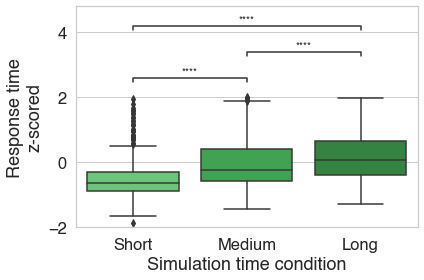

In [61]:
# Custom palette
custom_palette = ['#5FD372', '#31B346', '#279039']
# Independent variable
x = 'simulation_time_condition'
# Dependent variable
y = 'participant_z_rt'
order = ['low','med','high']

ax = sns.boxplot(data=df_exp1, x=x, y=y, order=order, palette=custom_palette)
# ax.axes.set_title('aa', pad=15)
ax.set_xlabel('Simulation time condition')
ax.set_ylabel('Response time\nz-scored')
ax.set(ylim=(-2,4.6))
ax.set(xticklabels=['Short', 'Medium', 'Long'])

pairs=[("low", "med"), ("med", "high"), ("low", "high")]
annotator = statannotator.Annotator(ax, pairs, data=df_exp1, x=x, y=y, order=order)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_test()
ax, test_results = annotator.annotate()
plt.tight_layout()
if saving_figures:
    plt.savefig(f'{figure_dir}/exp1_results_a.pdf')

### Blended model parameters

In [62]:
# Directory with model fits
path_to_model_predictions = "../data/model_fits/model_fits_exp1.csv"

In [63]:
# Dataframe with model fits
model_df = pd.read_csv(path_to_model_predictions)

In [94]:
# Sort model parameters based on MSE
best_fitting_parameters = model_df[model_df['MSE Model'] <= min(model_df['MSE Model'])]
best_fitting_parameters_exp1 = best_fitting_parameters
best_fitting_parameters

,N,D,E,MSE Residual,MSE Model,MSE Total
1894691,42,386,0.91,0.24696,1.981384e-10,0.241706


In [95]:
# Grab the best fitting parameters
n = list(best_fitting_parameters['N'])[0]
d = list(best_fitting_parameters['D'])[0]
e = list(best_fitting_parameters['E'])[0]
n,d,e

(42, 386, 0.9100000000000004)

In [96]:
# Path to jsons of scenes
path_to_scene_dir_exp1 = "../data/json/experiment1/"

In [97]:
# Gather JSON files of scenes from Experiment 1
scene_json_files_exp1 = [pos_json for pos_json in os.listdir(path_to_scene_dir_exp1) if pos_json.endswith('.json')]

In [98]:
# Model results
# Blended model
model_blended_results_exp1 = pd.DataFrame({})
# Pure simulation model
model_simulation_results_exp1 = pd.DataFrame({})
# Pure abstraction model
model_abstraction_results_exp1 = pd.DataFrame({})
# Number of samples to take from each model
samples = 50
# Set up inference models
blended_model_parameters = {
    'view': False,
    'noise': 0.00,
    'N': n,
    'D': d,
    'E': e,
}
abstraction_model_parameters = {
    'view': False,
    'noise': 0.00,
    'N': 1,
    'D': d,
    'E': 0.0,
}
simulation_model_parameters = {
    'view': False,
    'noise': 0.0,
}

#### Blended model

In [99]:
for scene_file in scene_json_files_exp1:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = os.path.join(path_to_scene_dir_exp1, scene_file)
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    blended_model = model_utilities.BlendedModel(
        blended_model_parameters
    )
    df_blended_model_output = pd.DataFrame({})
    # Sample model N times
    for _ in range(samples):
        blended_model_sample = blended_model.sample(scene_model)
        blended_model_sample = blended_model_sample.model_dump()
        df_blended_model_sample = pd.DataFrame(blended_model_sample, index=[0])
        df_blended_model_output = pd.concat([df_blended_model_output, df_blended_model_sample])
    # Collect statistics from samples
    df_blended_result = pd.DataFrame(
        {'scene':scene_name,
         'collision_probability':np.mean(df_blended_model_output['collision']),
         'simulation_time':df_blended_model_output['simulation_ticks'],
         'type':'blended_model'
        }
    )
    # Update results
    model_blended_results_exp1 = pd.concat([model_blended_results_exp1,df_blended_result])

#### Simulation model

In [100]:
for scene_file in scene_json_files_exp1:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = os.path.join(path_to_scene_dir_exp1, scene_file)
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    simulation_model = model_utilities.SimulationModel(
        simulation_model_parameters
    )
    df_simulation_model_output = pd.DataFrame({})
    for _ in range(samples):
        simulation_model_sample = simulation_model.sample(scene_model)
        simulation_model_sample = simulation_model_sample.model_dump()
        df_simulation_model_sample = pd.DataFrame(simulation_model_sample, index=[0])
        df_simulation_model_output = pd.concat([df_simulation_model_output, df_simulation_model_sample])
    # Append those results to dataframe
    df_simulation_result = pd.DataFrame(
        {'scene':scene_name,
         'collision_probability':np.mean(df_simulation_model_output['collision']),
         'simulation_time':df_simulation_model_output['simulation_ticks'],
         'type':'blended_model'
        }
    )
    model_simulation_results_exp1 = pd.concat([model_simulation_results_exp1,df_simulation_result])

#### Abstraction model

In [101]:
for scene_file in scene_json_files_exp1:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = os.path.join(path_to_scene_dir_exp1, scene_file)
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    abstraction_model = model_utilities.BlendedModel(
        abstraction_model_parameters
    )
    df_abstraction_model_output = pd.DataFrame({})
    # Sample model N times
    for _ in range(samples):
        abstraction_model_sample = abstraction_model.sample(scene_model)
        abstraction_model_sample = abstraction_model_sample.model_dump()
        df_abstraction_model_sample = pd.DataFrame(abstraction_model_sample, index=[0])
        df_abstraction_model_output = pd.concat([df_abstraction_model_output, df_abstraction_model_sample])
    # Collect statistics from samples
    df_abstraction_result = pd.DataFrame(
        {'scene':scene_name,
         'collision_probability':np.mean(df_abstraction_model_output['collision']),
         'simulation_time':df_abstraction_model_output['simulation_ticks'],
         'type':'blended_model'
        }
    )
    # Update results
    model_abstraction_results_exp1 = pd.concat([model_abstraction_results_exp1,df_abstraction_result])

In [102]:
model_blended_results_exp1['mean_simulation_time'] = model_blended_results_exp1.groupby('scene').simulation_time.transform(np.mean)
model_blended_results_exp1['mean_simulation_time_z'] = model_blended_results_exp1.mean_simulation_time.transform(lambda x: (x-x.mean())/x.std())

In [103]:
model_simulation_results_exp1['mean_simulation_time'] = model_simulation_results_exp1.groupby('scene').simulation_time.transform(np.mean)
model_simulation_results_exp1['mean_simulation_time_z'] = model_simulation_results_exp1.mean_simulation_time.transform(lambda x: (x-x.mean())/x.std())

In [104]:
model_abstraction_results_exp1['mean_simulation_time'] = model_abstraction_results_exp1.groupby('scene').simulation_time.transform(np.mean)
model_abstraction_results_exp1['mean_simulation_time_z'] = model_abstraction_results_exp1.mean_simulation_time.transform(lambda x: (x-x.mean())/x.std())

In [105]:
mean_rt_blended = pd.DataFrame(model_blended_results_exp1.groupby('scene').mean_simulation_time_z)
mean_rt_blended = mean_rt_blended.rename(columns = {0:'scene',1:'mean_rt_z_blended'})
mean_rt_blended.mean_rt_z_blended = mean_rt_blended.mean_rt_z_blended.transform(lambda x: list(x)[1])

In [106]:
mean_rt_simulation = pd.DataFrame(model_simulation_results_exp1.groupby('scene').mean_simulation_time_z)
mean_rt_simulation = mean_rt_simulation.rename(columns = {0:'scene',1:'mean_rt_z_simulation'})
mean_rt_simulation.mean_rt_z_simulation = mean_rt_simulation.mean_rt_z_simulation.transform(lambda x: list(x)[1])

In [107]:
mean_rt_abstraction = pd.DataFrame(model_abstraction_results_exp1.groupby('scene').mean_simulation_time_z)
mean_rt_abstraction = mean_rt_abstraction.rename(columns = {0:'scene',1:'mean_rt_z_abstraction'})
mean_rt_abstraction.mean_rt_z_abstraction = mean_rt_abstraction.mean_rt_z_abstraction.transform(lambda x: list(x)[1])

In [108]:
mean_rt_empirical = pd.DataFrame(df_exp1.groupby('scene').participant_z_rt.mean())
mean_rt_empirical = mean_rt_empirical.rename(columns = {0:'scene','participant_z_rt':'mean_rt_z_empirical'})
mean_rt_empirical = mean_rt_empirical.reset_index()

In [109]:
full_rt_empirical = df_exp1[['scene','participant_z_rt','subject_id']]

In [110]:
full_rt = full_rt_empirical.merge(mean_rt_simulation, on='scene')
full_rt = full_rt.merge(mean_rt_blended, on='scene')
mean_rt = full_rt.merge(mean_rt_abstraction, on='scene')
full_rt['path_condition'] = full_rt.scene.apply(lambda x: 'not_straight' if 'nosp' in x else 'straight')

In [111]:
mean_rt = mean_rt_empirical.merge(mean_rt_simulation, on='scene')
mean_rt = mean_rt.merge(mean_rt_blended, on='scene')
mean_rt = mean_rt.merge(mean_rt_abstraction, on='scene')
mean_rt['path_condition'] = mean_rt.scene.apply(lambda x: 'not_straight' if 'nosp' in x else 'straight')

In [112]:
# Formula for empirical data to blended model
emp_blended_formula = 'mean_rt_z_empirical ~ mean_rt_z_blended'

# Ordinary linear models based on path condition for empirical data
blended_model_predictions = smf.ols(
    emp_blended_formula,
    mean_rt
).fit()

# Parameters from both models
intercept = blended_model_predictions.params.Intercept
coefficient = blended_model_predictions.params.mean_rt_z_blended

mean_rt['mean_rt_z_blended_fit'] = mean_rt.mean_rt_z_blended.apply(lambda x: intercept + coefficient*x)

In [113]:
blended_model_predictions.params

Intercept           -0.119309
mean_rt_z_blended    0.107037
dtype: float64

In [118]:
mean_rt = mean_rt[mean_rt.mean_rt_z_abstraction <= 3]

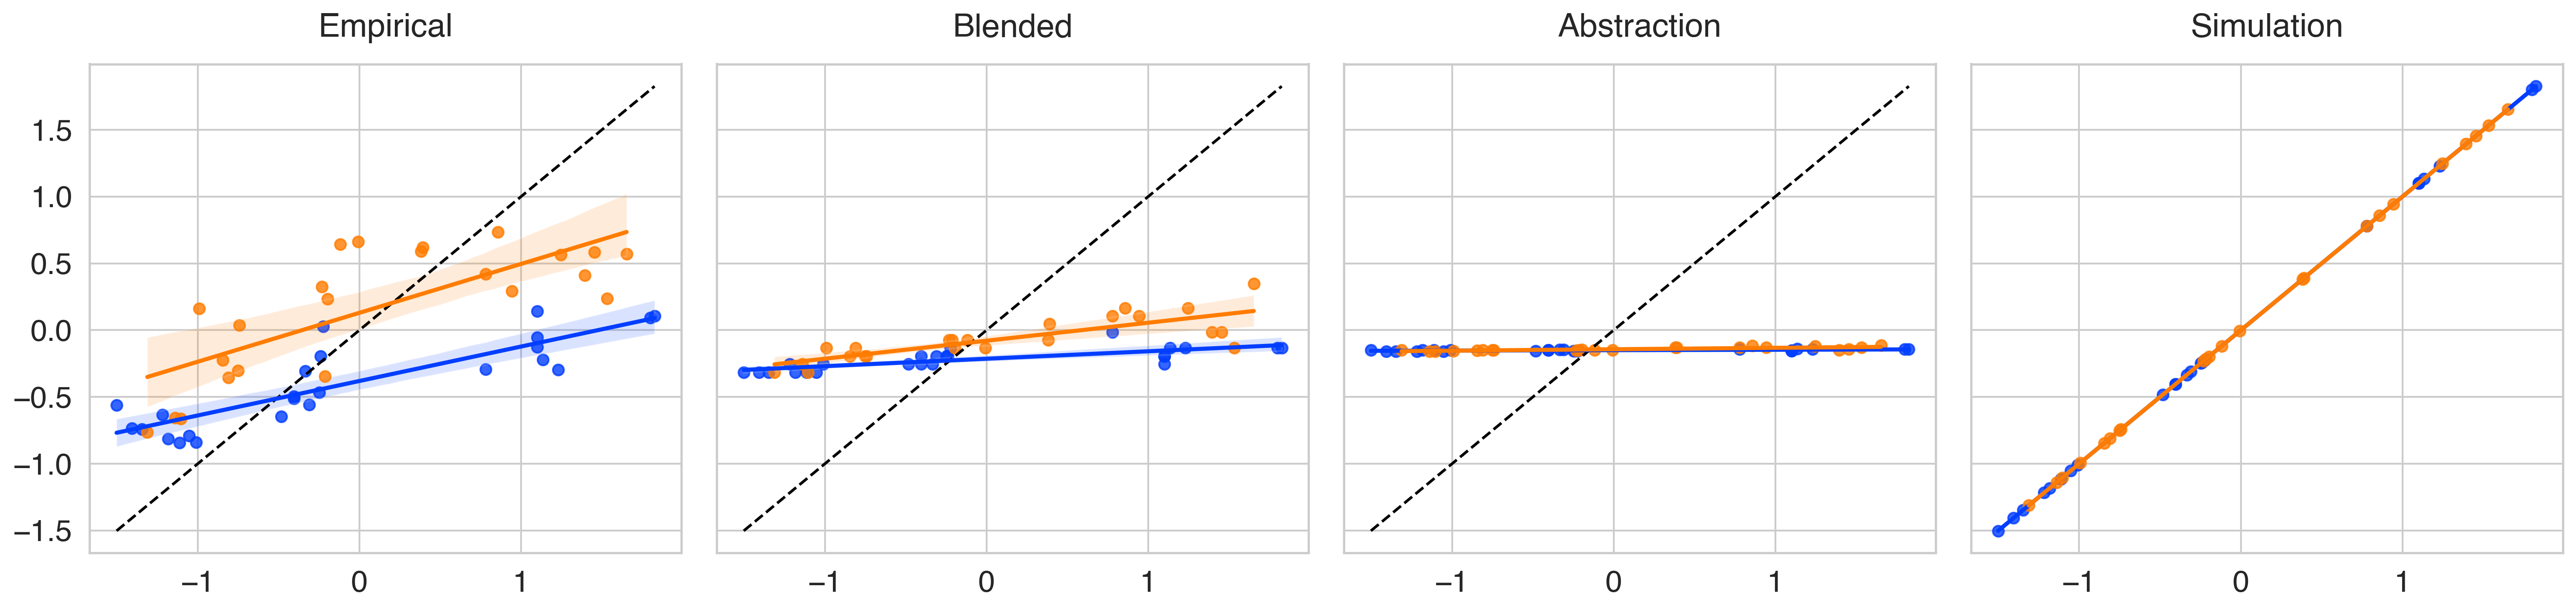

In [119]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True, sharex=True)
# sns.set(rc={'figure.figsize':(5,2)})
sns.set_theme(
    style='whitegrid',
    palette='bright',
    font_scale=1.5,
    rc={
        'figure.dpi':300,
        'font.family':'sans-serif',
        'font.sans-serif':['Helvetica'],
        'figure.figsize':(20,5),
    },
)

x = np.linspace(
    min(mean_rt.mean_rt_z_simulation),
    max(mean_rt.mean_rt_z_simulation)
)
ax1.plot(x, 
        x, 
        linestyle='dashed',
        label='Simulation',
        color='Black',
       )
ax2.plot(x, 
        x, 
        linestyle='dashed',
        label='Simulation',
        color='Black',
       )
ax3.plot(x, 
        x, 
        linestyle='dashed',
        label='Simulation',
        color='Black',
       )
ax4.plot(x, 
        x, 
        linestyle='dashed',
        label='Simulation',
        color='Black',
       )
# Empirical
sns.regplot(x='mean_rt_z_simulation',
            y='mean_rt_z_empirical', 
            data=mean_rt[mean_rt.path_condition == 'straight'], 
            label="Straight path",
            ax=ax1
           )
sns.regplot(x='mean_rt_z_simulation',
            y='mean_rt_z_empirical',
            data=mean_rt[mean_rt.path_condition == 'not_straight'],
            label="No straight path",
            ax=ax1
           )
# Blended
sns.regplot(x='mean_rt_z_simulation',
            y='mean_rt_z_blended', 
            data=mean_rt[mean_rt.path_condition == 'straight'], 
            label="Straight path",
            ax=ax2
           )
sns.regplot(x='mean_rt_z_simulation',
            y='mean_rt_z_blended',
            data=mean_rt[mean_rt.path_condition == 'not_straight'],
            label="No straight path",
            ax=ax2
           )
# Abstraction
sns.regplot(x='mean_rt_z_simulation',
            y='mean_rt_z_abstraction', 
            data=mean_rt[mean_rt.path_condition == 'straight'], 
            label="Straight path",
            ax=ax3
           )
sns.regplot(x='mean_rt_z_simulation',
            y='mean_rt_z_abstraction',
            data=mean_rt[mean_rt.path_condition == 'not_straight'],
            label="No straight path",
            ax=ax3
           )
# Simulation
sns.regplot(x='mean_rt_z_simulation',
            y='mean_rt_z_simulation', 
            data=mean_rt[mean_rt.path_condition == 'straight'], 
            label="Straight path",
            ax=ax4
           )
sns.regplot(x='mean_rt_z_simulation',
            y='mean_rt_z_simulation',
            data=mean_rt[mean_rt.path_condition == 'not_straight'],
            label="No straight path",
            ax=ax4
           )
# ax1.set(ylim=(-2.1,2.1),xlim=(-3.1,3.1))
ax1.set_title('Empirical', pad=15)
ax2.set_title('Blended', pad=15)
ax3.set_title('Abstraction', pad=15)
ax4.set_title('Simulation', pad=15)
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax1.set_ylabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
plt.tight_layout()
if True:
    plt.savefig(f'{figure_dir}/exp1_results_panel.pdf')

In [125]:
mse_empirical_blended = np.mean((mean_rt['mean_rt_z_empirical'] - mean_rt['mean_rt_z_blended'])**2)
mle_blended = -58/2*(np.log(2*np.pi*mse_empirical_blended)+1)

mse_empirical_simulation = np.mean((mean_rt['mean_rt_z_empirical'] - mean_rt['mean_rt_z_simulation'])**2)
mle_simulation = -58/2*(np.log(2*np.pi*mse_empirical_simulation)+1)

mse_empirical_abstraction = np.mean((mean_rt['mean_rt_z_empirical'] - mean_rt['mean_rt_z_abstraction'])**2)
mle_abstraction = -58/2*(np.log(2*np.pi*mse_empirical_abstraction)+1)

In [126]:
mse_empirical_blended

0.14715796802782757

In [129]:
mle_blended

-26.72722388006814

In [130]:
mse_empirical_abstraction
mle_abstraction

-40.01542516505461

In [131]:
mse_empirical_simulation
mle_simulation

-67.5174513994839

In [138]:
# BIC
3*np.log(len(mean_rt)) - 2*np.log(-1*mle_blended)

4.979077471285889

In [137]:
# BIC
3*np.log(len(mean_rt)) - 2*np.log(-1*mle_abstraction)

4.171912787321174

Do not allow slope to change with condition. 

In [70]:
from pymer4.models import Lmer

In [74]:
formula = 'participant_z_rt ~ mean_rt_z_simulation + path_condition + mean_rt_z_simulation*path_condition + (mean_rt_z_simulation + path_condition + mean_rt_z_simulation*path_condition | subject_id)'

In [75]:
model = Lmer(formula, data=full_rt)

model.fit()

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: participant_z_rt~mean_rt_z_simulation+path_condition+mean_rt_z_simulation*path_condition+(mean_rt_z_simulation+path_condition+mean_rt_z_simulation*path_condition|subject_id)

Family: gaussian	 Inference: parametric

Number of observations: 2151	 Groups: {'subject_id': 47.0}

Log-likelihood: -1980.259 	 AIC: 3990.517

Random effects:

                                                   Name    Var    Std
subject_id                                  (Intercept)  0.000  0.000
subject_id                         mean_rt_z_simulation  0.015  0.122
subject_id                       path_conditionstraight  0.002  0.050
subject_id  mean_rt_z_simulation:path_conditionstraight  0.022  0.149
Residual                                                 0.356  0.597

                               IV1  \
subject_id             (Intercept)   
subject_id             (Intercept)   
subject_id             (Int

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.119,0.083,0.155,0.019,2041.331,6.409,0.000,***
mean_rt_z_simulation,0.371,0.319,0.423,0.027,50.119,13.915,0.000,***
path_conditionstraight,-0.500,-0.553,-0.448,0.027,203.406,-18.638,0.000,***
mean_rt_z_simulation:path_conditionstraight,-0.113,-0.180,-0.046,0.034,46.705,-3.322,0.002,**


In [76]:
# Gather JSON files of scenes from Experiment 2
scene_json_files_exp1 = [pos_json for pos_json in os.listdir(path_to_scene_dir_exp1) if pos_json.endswith('.json')]
distance_df = pd.DataFrame({})
for scene_file in scene_json_files_exp1:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = os.path.join(path_to_scene_dir_exp1, scene_file)
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    simulation_model = model_utilities.SimulationModel(
        {'view': False, 'noise': 0}
    )
    df_simulation_model_output = pd.DataFrame({})
    simulation_model_sample = simulation_model.sample(scene_model)
    simulation_model_sample = simulation_model_sample.model_dump()
    df_simulation_model_sample = pd.DataFrame(simulation_model_sample, index=[0])
    # Append those results to dataframe
    scene_distance_df = pd.DataFrame(
        {'scene':scene_name,
         'distance':df_simulation_model_sample['trajectory_length']
        }
    )
    distance_df = pd.concat([distance_df,scene_distance_df])

In [78]:
full_rt = full_rt.merge(distance_df, on='scene')

In [112]:
mean_rt_simulation['model'] = 'simulation'
mean_rt_simulation = mean_rt_simulation.rename(columns={'mean_rt_z_simulation': 'rt_z'})

mean_rt_blended['model'] = 'blended'
mean_rt_blended = mean_rt_blended.rename(columns={'mean_rt_z_blended': 'rt_z'})

mean_rt_abstraction['model'] = 'abstraction'
mean_rt_abstraction = mean_rt_abstraction.rename(columns={'mean_rt_z_abstraction': 'rt_z'})

mean_rt_empirical['model'] = 'empirical'
mean_rt_empirical = mean_rt_empirical.rename(columns={'mean_rt_z_empirical': 'rt_z'})

In [113]:
mean_rt_full = pd.concat([mean_rt_simulation, mean_rt_blended, mean_rt_abstraction, mean_rt_empirical])

In [114]:
mean_rt_full = mean_rt_full.merge(distance_df, on='scene')

In [115]:
mean_rt_full

,scene,rt_z,model,distance
0,high_nocol_nosp_1,0.944429,simulation,961.625005
1,high_nocol_nosp_1,-0.438383,blended,961.625005
2,high_nocol_nosp_1,-0.467450,abstraction,961.625005
3,high_nocol_nosp_1,0.293383,empirical,961.625005
4,high_nocol_nosp_2,1.532267,simulation,1292.809862
...,...,...,...,...
187,med_yescol_yessp_3,-0.558187,empirical,829.673132
188,med_yescol_yessp_4,-0.334981,simulation,806.887435
189,med_yescol_yessp_4,-0.438383,blended,806.887435
190,med_yescol_yessp_4,-0.467450,abstraction,806.887435


In [118]:
df = mean_rt_simulation.rename(columns={'rt_z':'rt_z_simulation'})[['scene','rt_z_simulation']]
df = df.merge(mean_rt_full, on='scene')

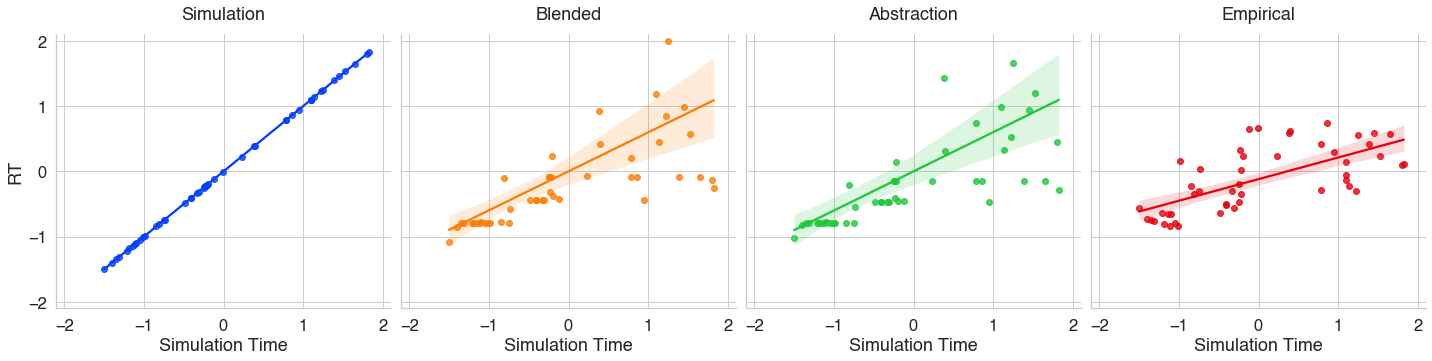

In [125]:
ax = sns.lmplot(
    data=df,
    x="rt_z_simulation",
    y="rt_z",
    hue='model',
    col='model',
#     y_jitter=.01,
)
ax.set(ylim=(-2.1,2.1), xlim=(-2.1,2.1))
axes = ax.axes.flatten()
axes[0].set_title('Simulation',pad=15)
axes[3].set_title('Empirical', pad=15)
axes[1].set_title('Blended', pad=15)
axes[2].set_title('Abstraction', pad=15)
ax.set_axis_labels(x_var='Simulation Time', y_var='RT')

# if saving_figures:
#     plt.savefig(f'{figure_dir}/exp2_results_a.pdf')


## Experiment 2

In [77]:
# Path to jsons of scenes
path_to_scene_dir_exp2 = "../../../Desktop/pydantic/experiment2/"

In [78]:
# Gather JSON files of scenes from Experiment 2
scene_json_files_exp2 = [pos_json for pos_json in os.listdir(path_to_scene_dir_exp2) if pos_json.endswith('.json')]

In [215]:
distance_df = pd.DataFrame({})
for scene_file in scene_json_files_exp2:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = path_to_scene_dir_exp2 + scene_file
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    simulation_model = model_utilities.SimulationModel(
        {'view': False, 'noise': 0}
    )
    df_simulation_model_output = pd.DataFrame({})
    simulation_model_sample = simulation_model.sample(scene_model)
    simulation_model_sample = simulation_model_sample.model_dump()
    df_simulation_model_sample = pd.DataFrame(simulation_model_sample, index=[0])
    # Append those results to dataframe
    scene_distance_df = pd.DataFrame(
        {'scene':scene_name,
         'distance':df_simulation_model_sample['trajectory_length']
        }
    )
    distance_df = pd.concat([distance_df,scene_distance_df])

In [198]:
# Model results
# Blended model
model_blended_results_exp2 = pd.DataFrame({})
# Pure simulation model
model_simulation_results_exp2 = pd.DataFrame({})
# Pure abstraction model
model_abstraction_results_exp2 = pd.DataFrame({})
# Number of samples to take from each model
samples = 50
# Set up inference models
blended_model_parameters = {
    'view': False,
    'noise': 0.02,
    'N': n,
    'D': d,
    'E': e,
}
abstraction_model_parameters = {
    'view': False,
    'noise': 0.02,
    'N': 1,
    'D': d,
    'E': 0.0,
}
simulation_model_parameters = {
    'view': False,
    'noise': 0.0,
}

In [206]:
for scene_file in scene_json_files_exp2:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = path_to_scene_dir_exp2 + scene_file
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    blended_model = model_utilities.BlendedModel(
        blended_model_parameters
    )
    df_blended_model_output = pd.DataFrame({})
    # Sample model N times
    for _ in range(samples):
        blended_model_sample = blended_model.sample(scene_model)
        blended_model_sample = blended_model_sample.model_dump()
        df_blended_model_sample = pd.DataFrame(blended_model_sample, index=[0])
        df_blended_model_output = pd.concat([df_blended_model_output, df_blended_model_sample])
    # Collect statistics from samples
    df_blended_result = pd.DataFrame(
        {'scene':scene_name,
         'collision_probability':np.mean(df_blended_model_output['collision']),
         'simulation_time':df_blended_model_output['simulation_ticks'],
         'distance':df_blended_model_output['trajectory_length'],
         'type':'blended_model'
        }
    )
    # Update results
    model_blended_results_exp2 = pd.concat([model_blended_results_exp2,df_blended_result])

In [200]:
for scene_file in scene_json_files_exp2:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = path_to_scene_dir_exp2 + scene_file
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    simulation_model = model_utilities.SimulationModel(
        simulation_model_parameters
    )
    df_simulation_model_output = pd.DataFrame({})
    for _ in range(samples):
        simulation_model_sample = simulation_model.sample(scene_model)
        simulation_model_sample = simulation_model_sample.model_dump()
        df_simulation_model_sample = pd.DataFrame(simulation_model_sample, index=[0])
        df_simulation_model_output = pd.concat([df_simulation_model_output, df_simulation_model_sample])
    # Append those results to dataframe
    df_simulation_result = pd.DataFrame(
        {'scene':scene_name,
         'collision_probability':np.mean(df_simulation_model_output['collision']),
         'simulation_time':df_simulation_model_output['simulation_ticks'],
         'distance':df_simulation_model_output['trajectory_length'],
         'type':'blended_model'
        }
    )
    model_simulation_results_exp2 = pd.concat([model_simulation_results_exp2,df_simulation_result])

In [201]:
for scene_file in scene_json_files_exp2:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = path_to_scene_dir_exp2 + scene_file
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    abstraction_model = model_utilities.BlendedModel(
        abstraction_model_parameters
    )
    df_abstraction_model_output = pd.DataFrame({})
    # Sample model N times
    for _ in range(samples):
        abstraction_model_sample = abstraction_model.sample(scene_model)
        abstraction_model_sample = abstraction_model_sample.model_dump()
        df_abstraction_model_sample = pd.DataFrame(abstraction_model_sample, index=[0])
        df_abstraction_model_output = pd.concat([df_abstraction_model_output, df_abstraction_model_sample])
    # Collect statistics from samples
    df_abstraction_result = pd.DataFrame(
        {'scene':scene_name,
         'collision_probability':np.mean(df_abstraction_model_output['collision']),
         'simulation_time':df_abstraction_model_output['simulation_ticks'],
         'distance':df_abstraction_model_output['trajectory_length'],
         'type':'blended_model'
        }
    )
    # Update results
    model_abstraction_results_exp2 = pd.concat([model_abstraction_results_exp2,df_abstraction_result])

In [254]:
blended_model_acc = model_blended_results_exp2.groupby('scene').collision_probability.mean().to_frame()
blended_model_acc['model'] = 'blended'
blended_model_acc = blended_model_acc.rename(columns={'collision_probability': 'correct'})

In [255]:
simulation_model_acc = model_simulation_results_exp2.groupby('scene').collision_probability.mean().to_frame()
simulation_model_acc['model'] = 'simulation'
simulation_model_acc = simulation_model_acc.rename(columns={'collision_probability': 'correct'})

In [256]:
abstraction_model_acc = model_abstraction_results_exp2.groupby('scene').collision_probability.mean().to_frame()
abstraction_model_acc['model'] = 'abstraction'
abstraction_model_acc = abstraction_model_acc.rename(columns={'collision_probability': 'correct'})

In [257]:
empirical_acc = df_exp2.groupby('scene').correct.mean().to_frame()
empirical_acc['model'] = 'empirical'

In [260]:
accuracy_df = pd.concat([simulation_model_acc, empirical_acc, blended_model_acc, abstraction_model_acc])

In [262]:
accuracy_df = accuracy_df.reset_index()
accuracy_df['goal_point_idx'] = accuracy_df.scene.apply(lambda x: x.split('_')[-1])
accuracy_df['scene_type'] = accuracy_df.scene.apply(lambda x: x.split('_')[1])
accuracy_df = accuracy_df.merge(distance_df, on='scene')

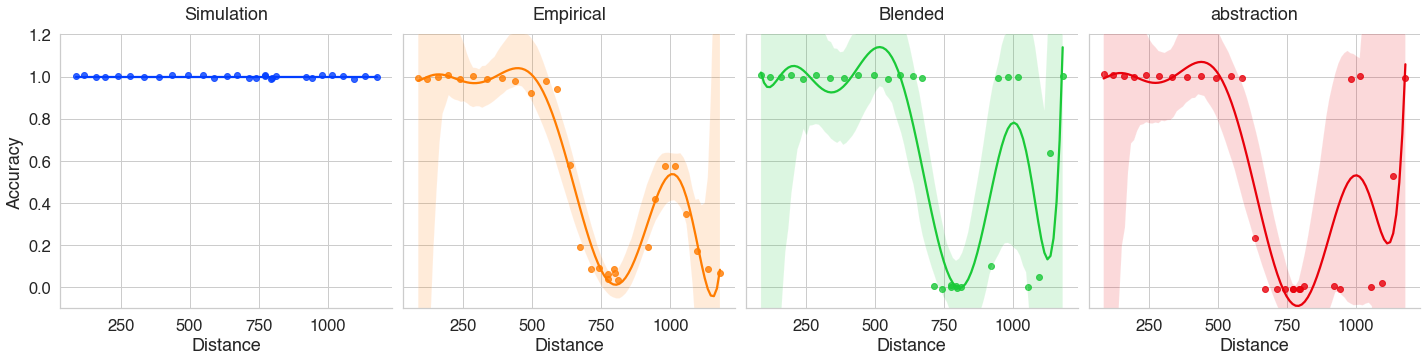

In [236]:
ax = sns.lmplot(
    data=accuracy_df[accuracy_df.scene_type =='1'],
    x="distance",
    y="correct",
    hue='model',
    order=8,
    col='model',
    y_jitter=.01,
)
ax.set(ylim=(-0.1,1.2))
axes = ax.axes.flatten()
axes[0].set_title('Simulation',pad=15)
axes[1].set_title('Empirical', pad=15)
axes[2].set_title('Blended', pad=15)
axes[3].set_title('abstraction', pad=15)
ax.set_axis_labels(x_var='Distance', y_var='Accuracy')

if saving_figures:
    plt.savefig(f'{figure_dir}/exp2_results_a.pdf')

In [292]:
pivot = accuracy_df.pivot(index='scene', columns='model', values='correct')
pivot = pivot.merge(distance_df, on ='scene')

In [293]:
# pivot['simulation'] = pivot.simulation.astype(float)
pivot['simulation'] = pivot.simulation.apply(lambda x: x*np.random.normal(1,0.001))

In [294]:
pivot.corr()

,abstraction,blended,empirical,simulation,distance
abstraction,1.000000,0.856732,0.877443,0.265363,-0.555626
blended,0.856732,1.000000,0.837694,0.103635,-0.515515
empirical,0.877443,0.837694,1.000000,0.176572,-0.733840
simulation,0.265363,0.103635,0.176572,1.000000,-0.055630
distance,-0.555626,-0.515515,-0.733840,-0.055630,1.000000


g = sns.FacetGrid(accuracy_df, col="model",  row="scene_type", hue='model')
g.map(sns.pointplot, "distance", "correct")
axes = g.axes.flatten()
axes[0].set_title('Simulation',pad=15)
axes[1].set_title('Empirical', pad=15)
axes[2].set_title('Blended', pad=15)
axes[3].set_title('Abstraction', pad=15)
g.set(xlim=(0, 1000))

# ax.set_titles(col_template='{col_name}')
# ax.set_axis_labels(x_var='Distance', y_var='Accuracy')

In [79]:
rtdir = "../data/rt_profiles_test_exp_comp_choice/"

In [80]:
def format_scene_data_into_dataframe(fname):
    sim_df = pd.read_json(fname)
    abs_df = pd.DataFrame.copy(sim_df,deep=True)
    
    sim_df = sim_df[['goal_x','goal_y','distance_from_origin',"distance_simulation",'goal_point_idx','runtime_simulation','goal_collision_simulation']]
    sim_df = sim_df.rename(
        columns={"runtime_simulation":"runtime",
                 "distance_simulation":"distance",
                "goal_collision_simulation":"collision"})

    abs_df = abs_df[['goal_x','goal_y','distance_from_origin',"distance_abstraction",'goal_point_idx','runtime_abstraction','goal_collision_abstraction']]
    abs_df = abs_df.rename(
        columns={"runtime_abstraction":"runtime",
                 "distance_abstraction":"distance",
                "goal_collision_abstraction":"collision"})
    
    sim_df['model'] = "simulation"
    abs_df['model'] = "abstraction"
    df = pd.concat([sim_df,abs_df])
    df['scene'] = fname.split('/')[-1]
    return df

In [81]:
rt_files = [pos_json for pos_json in os.listdir(rtdir) if pos_json.endswith('.json')]
rt_df = pd.DataFrame({})
for scene in rt_files:
    print(scene)
    df = format_scene_data_into_dataframe(rtdir+scene)
    rt_df = pd.concat([rt_df,df])

scene_2.json
scene_1.json


In [82]:
rt_df['rt_z'] = rt_df.runtime.transform(lambda x: (x-x.mean()) / x.std())
rt_df = rt_df[abs(rt_df.rt_z) <= 2]

In [83]:
rt_df = rt_df.rename(columns={'scene':'scene_type'})
rt_df['scene_type'] = rt_df['scene_type'].apply(lambda x: x.split('.')[0])
rt_df['scene'] = rt_df['scene_type']+'_'+rt_df['goal_point_idx'].astype(str)

In [84]:
emp_df = df_exp2[['participant_z_rt', 'scene_type','scene','scene_index','correct']]
emp_df = emp_df.rename(columns={'participant_z_rt' : 'rt_z','correct':'collision', 'scene_index': 'goal_point_idx'})
emp_df['model'] = "empirical"

In [85]:
model_df = rt_df[['rt_z', 'scene_type','scene','goal_point_idx','collision','model']]

In [87]:
full_df = pd.concat([emp_df,model_df])

In [90]:
straight_path_true = list(range(13))
straight_path_false = [27, 28]
not_straight_path = list(range(13,27))

def sp(x):
    if "scene_2" in x:
        return "straight_path_true"
    split = x.split("_")
    scene_type = int(split[1])
    goal_idx = int(split[-1])
    if scene_type == 2:
        return "straight_path"
    if goal_idx in straight_path_true:
        return "straight_path_true"
    elif goal_idx in straight_path_false:
        return "not_straight_path"
    elif goal_idx in not_straight_path:
        return "not_straight_path"

In [91]:
full_df['sp'] = full_df.scene.apply(lambda x: sp(x))

In [92]:
acc = pd.DataFrame(full_df.groupby(['scene','model','sp']).collision.mean())
rt = pd.DataFrame(full_df.groupby(['scene','model','sp']).rt_z.mean())

In [94]:
rt

rt_z
scene     model       sp                          
scene_1_0 abstraction straight_path_true -0.559612
          empirical   straight_path_true -0.720819
          simulation  straight_path_true -0.341263
scene_1_1 abstraction straight_path_true -0.498418
          empirical   straight_path_true -0.634978
...                                            ...
scene_2_8 empirical   straight_path_true -0.520280
          simulation  straight_path_true -0.074425
scene_2_9 abstraction straight_path_true -0.519856
          empirical   straight_path_true -0.476691
          simulation  straight_path_true -0.043166

[174 rows x 1 columns]

In [248]:
simulation_model_parameters = {
    'view': False,
    'noise': 0
}

In [274]:
for scene_file in scene_json_files_exp2:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = path_to_scene_dir_exp2 + scene_file
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    simulation_model = model_utilities.SimulationModel(
        simulation_model_parameters
    )
    df_simulation_model_output = pd.DataFrame({})
    simulation_model_sample = simulation_model.sample(scene_model)
    simulation_model_sample = simulation_model_sample.model_dump()
    df_simulation_model_sample = pd.DataFrame(simulation_model_sample, index=[0])
    # Append those results to dataframe
    df_simulation_result = pd.DataFrame(
        {'scene':scene_name,
         'collision_probability':np.mean(df_simulation_model_sample['collision']),
         'simulation_time':df_simulation_model_sample['simulation_ticks'],
         'distance': df_simulation_model_sample['trajectory_length'],
         'type':'blended_model'
        }
    )
    model_simulation_results_exp2 = pd.concat([model_simulation_results_exp1,df_simulation_result])

In [275]:
model_simulation_results_exp2

,scene,collision_probability,simulation_time,type,mean_simulation_time,mean_simulation_time_z,distance
0,med_nocol_nosp_1,0.0,256,blended_model,256.0,0.382526,NaN
0,med_nocol_nosp_1,0.0,256,blended_model,256.0,0.382526,NaN
0,med_nocol_nosp_1,0.0,256,blended_model,256.0,0.382526,NaN
0,med_nocol_nosp_1,0.0,256,blended_model,256.0,0.382526,NaN
0,med_nocol_nosp_1,0.0,256,blended_model,256.0,0.382526,NaN
...,...,...,...,...,...,...,...
0,scene_2_25,1.0,162,blended_model,NaN,NaN,NaN
0,scene_1_23,1.0,236,blended_model,NaN,NaN,NaN
0,scene_2_8,1.0,84,blended_model,NaN,NaN,NaN
0,scene_1_19,1.0,177,blended_model,NaN,NaN,NaN


# Miscellaneous Figure Plots

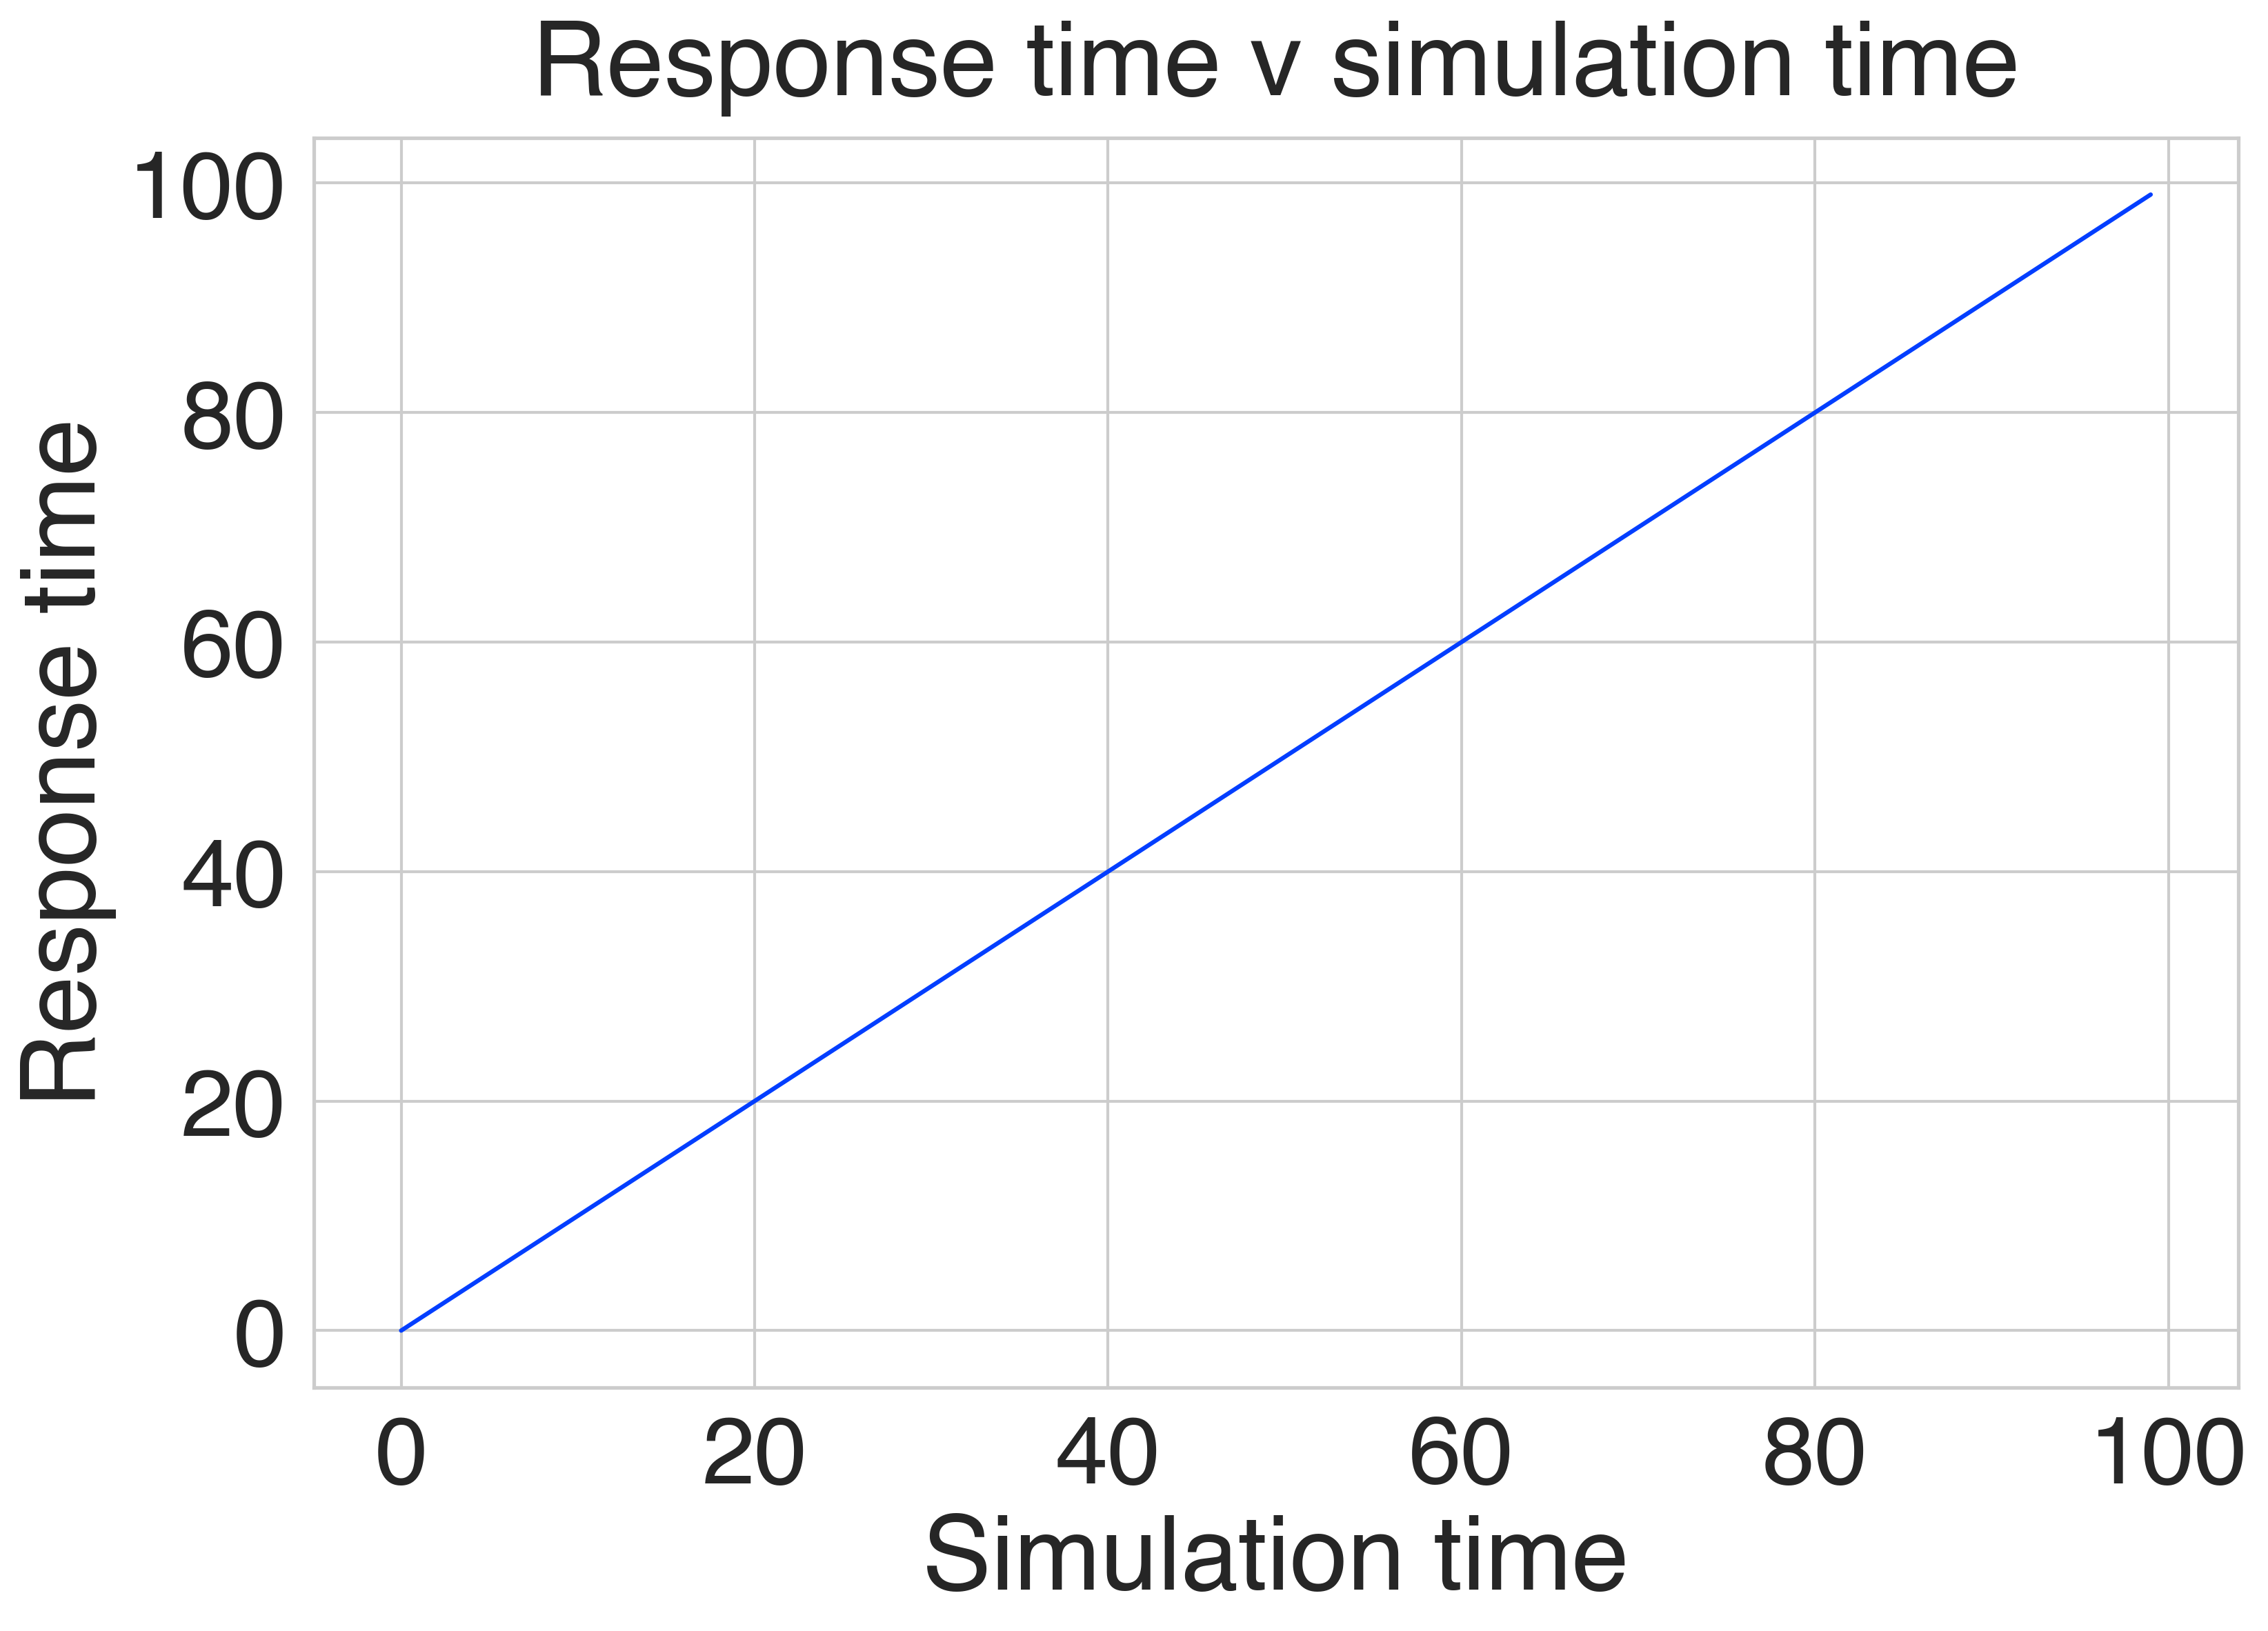

In [325]:
# Figure 1
df_figure1_plot = pd.DataFrame({
    'Simulation time':list(range(100)),
    'Response time':list(range(100))
})
ax = sns.lineplot(data=df_figure1_plot, x='Simulation time', y='Response time')
ax.axes.set_title('Response time v simulation time', pad=15)
if saving_figures:
    plt.savefig(f'{figure_dir}/example_rt_a.pdf')

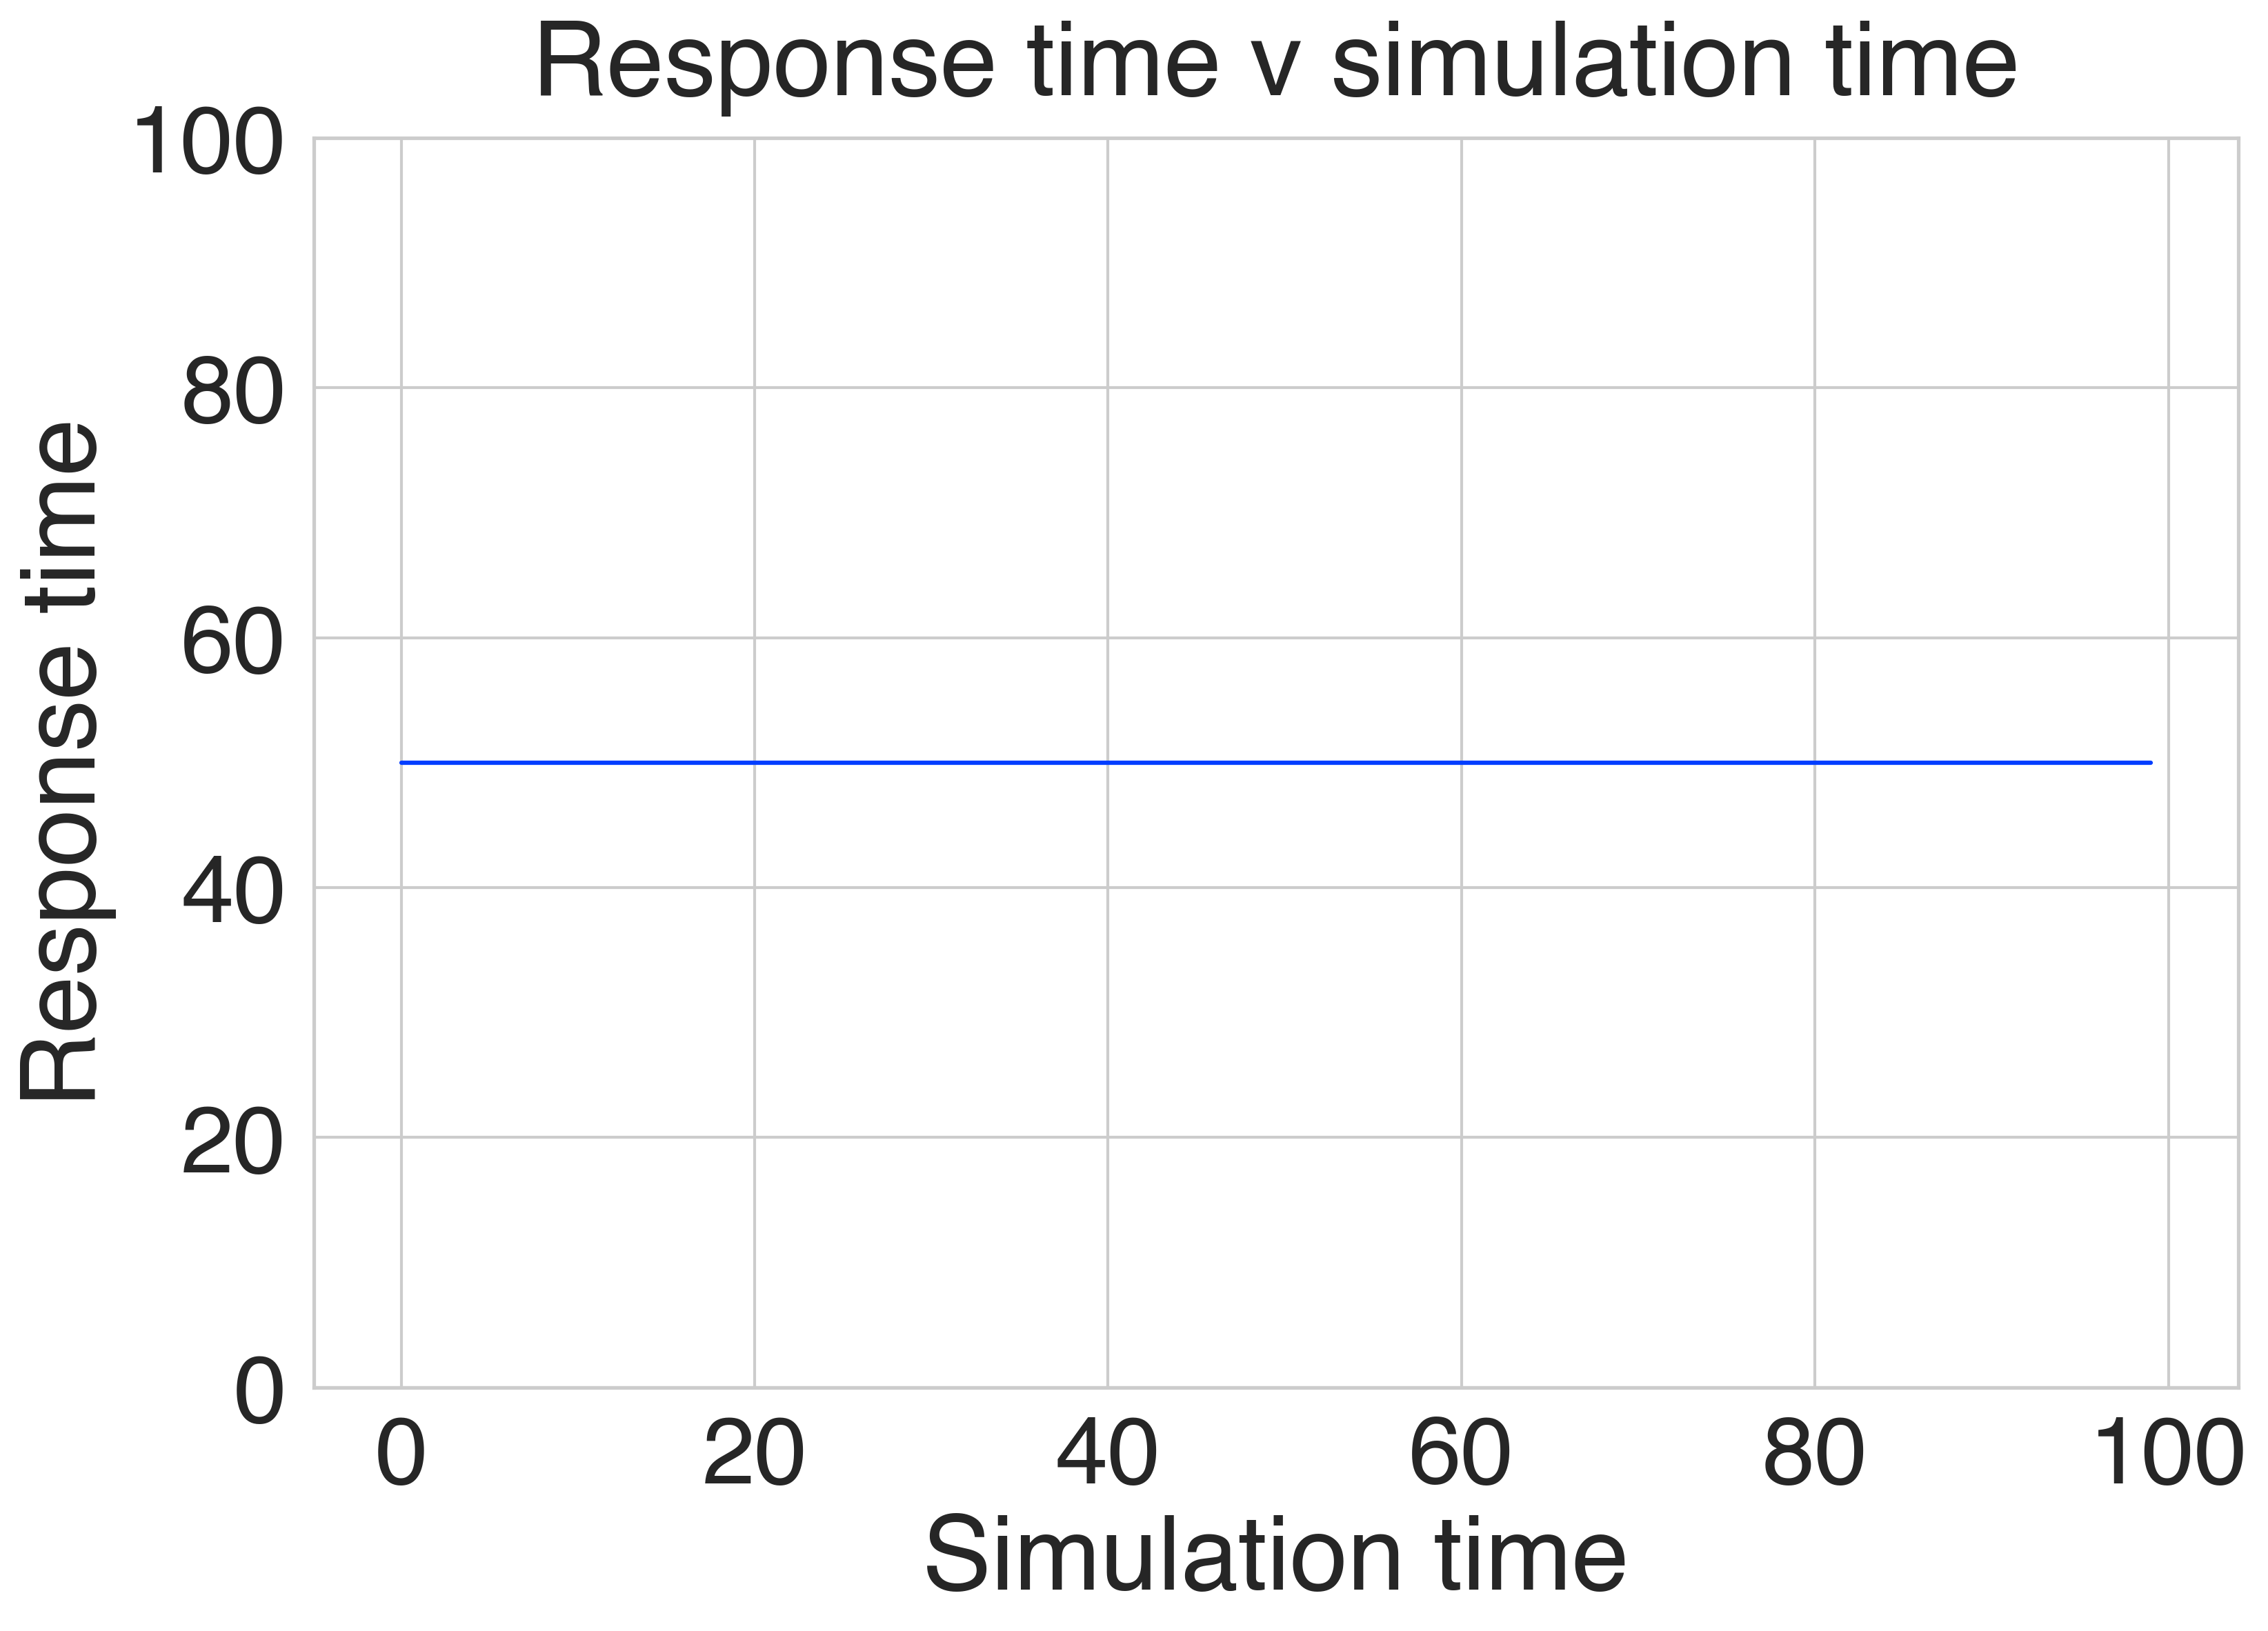

In [327]:
# Figure 1
df_figure1_plot = pd.DataFrame({
    'Simulation time':list(range(100)),
    'Response time':[50]*100
})
ax = sns.lineplot(data=df_figure1_plot, x='Simulation time', y='Response time')
ax.axes.set_title('Response time v simulation time', pad=15)
ax.set(ylim=(0,100))
if saving_figures:
    plt.savefig(f'{figure_dir}/example_rt_b.pdf')

In [105]:
straight_path_true = list(range(13))
straight_path_false = [27, 28]
not_straight_path = list(range(13,27))

In [106]:
def format_scene_data_into_dataframe(fname):
    sim_df = pd.read_json(fname)
    abs_df = pd.DataFrame.copy(sim_df,deep=True)
    
    sim_df = sim_df[['goal_x','goal_y',
                     'distance_from_origin',"distance_simulation",
                     'goal_point_idx','runtime_simulation',
                     'goal_collision_simulation','comp_choice_simulation']]
    sim_df = sim_df.rename(
        columns={"runtime_simulation":"runtime",
                 "distance_simulation":"distance",
                "goal_collision_simulation":"collision",
                'comp_choice_simulation':'comp_choice'})
    

    abs_df = abs_df[['goal_x','goal_y',
                     'distance_from_origin',"distance_abstraction",
                     'goal_point_idx','runtime_abstraction',
                     'goal_collision_abstraction','comp_choice_abstraction']]
    abs_df = abs_df.rename(
        columns={"runtime_abstraction":"runtime",
                 "distance_abstraction":"distance",
                "goal_collision_abstraction":"collision",
                'comp_choice_abstraction':'comp_choice'})
    
    sim_df['model'] = "simulation"
    abs_df['model'] = "abstraction"
    df = pd.concat([sim_df,abs_df])
    df['scene'] = fname.split('/')[-1]
    return df

In [107]:
rtdir = "../data/rt_profiles_test_exp_comp_choice/"

In [108]:
def format_scene_data_into_dataframe(fname):
    sim_df = pd.read_json(fname)
    abs_df = pd.DataFrame.copy(sim_df,deep=True)
    
    sim_df = sim_df[
        ['goal_x',
         'goal_y',
         'distance_from_origin',
         "distance_simulation",
         'goal_point_idx',
         'runtime_simulation',
         'goal_collision_simulation'
        ]
    ]
    sim_df = sim_df.rename(
        columns={"runtime_simulation":"runtime",
                 "distance_simulation":"distance",
                "goal_collision_simulation":"collision"})

    abs_df = abs_df[
        ['goal_x',
         'goal_y',
         'distance_from_origin',
         "distance_abstraction",
         'goal_point_idx',
         'runtime_abstraction',
         'goal_collision_abstraction'
        ]
    ]
    abs_df = abs_df.rename(
        columns={"runtime_abstraction":"runtime",
                 "distance_abstraction":"distance",
                "goal_collision_abstraction":"collision"})
    
    sim_df['model'] = "simulation"
    abs_df['model'] = "abstraction"
    df = pd.concat([sim_df,abs_df])
    df['scene'] = fname.split('/')[-1]
    return df

In [109]:
rt_files = [pos_json for pos_json in os.listdir(rtdir) if pos_json.endswith('.json')]
rt_df = pd.DataFrame({})
for scene in rt_files:
    print(scene)
    df = format_scene_data_into_dataframe(rtdir+scene)
    rt_df = pd.concat([rt_df,df])

scene_2.json
scene_1.json


In [110]:
rt_df

,goal_x,goal_y,distance_from_origin,distance,goal_point_idx,runtime,collision,model,scene
0,376.266068,167.209738,14.384212,73.308883,0,45,1,simulation,scene_2.json
1,376.266068,167.209738,14.384212,73.308883,0,45,1,simulation,scene_2.json
2,376.266068,167.209738,14.384212,73.308883,0,45,1,simulation,scene_2.json
3,376.266068,167.209738,14.384212,70.237665,0,44,1,simulation,scene_2.json
4,376.266068,167.209738,14.384212,73.308883,0,45,1,simulation,scene_2.json
...,...,...,...,...,...,...,...,...,...
2895,364.764537,915.438120,763.012985,1161.873746,28,85,0,abstraction,scene_1.json
2896,364.764537,915.438120,763.012985,1163.208417,28,85,0,abstraction,scene_1.json
2897,364.764537,915.438120,763.012985,1134.924874,28,85,0,abstraction,scene_1.json
2898,364.764537,915.438120,763.012985,1164.995021,28,85,0,abstraction,scene_1.json


In [111]:
rt_df['rt_z'] = rt_df.runtime.transform(lambda x: (x-x.mean()) / x.std())
rt_df = rt_df[abs(rt_df.rt_z) <= 2]

In [112]:
rt_df = rt_df.rename(columns={'scene':'scene_type'})
rt_df['scene_type'] = rt_df['scene_type'].apply(lambda x: x.split('.')[0])
rt_df['scene'] = rt_df['scene_type']+'_'+rt_df['goal_point_idx'].astype(str)
rt_df

,goal_x,goal_y,distance_from_origin,distance,goal_point_idx,runtime,collision,model,scene_type,rt_z,scene
0,376.266068,167.209738,14.384212,73.308883,0,45,1,simulation,scene_2,-0.386164,scene_2_0
1,376.266068,167.209738,14.384212,73.308883,0,45,1,simulation,scene_2,-0.386164,scene_2_0
2,376.266068,167.209738,14.384212,73.308883,0,45,1,simulation,scene_2,-0.386164,scene_2_0
3,376.266068,167.209738,14.384212,70.237665,0,44,1,simulation,scene_2,-0.393960,scene_2_0
4,376.266068,167.209738,14.384212,73.308883,0,45,1,simulation,scene_2,-0.386164,scene_2_0
...,...,...,...,...,...,...,...,...,...,...,...
2895,364.764537,915.438120,763.012985,1161.873746,28,85,0,abstraction,scene_1,-0.074347,scene_1_28
2896,364.764537,915.438120,763.012985,1163.208417,28,85,0,abstraction,scene_1,-0.074347,scene_1_28
2897,364.764537,915.438120,763.012985,1134.924874,28,85,0,abstraction,scene_1,-0.074347,scene_1_28
2898,364.764537,915.438120,763.012985,1164.995021,28,85,0,abstraction,scene_1,-0.074347,scene_1_28


In [113]:
data = "../experiments/experiment2/data/data.csv"
df = pd.read_csv(data)

In [114]:
df = df.drop(columns=['success', 
                          'failed_images',
                          'failed_audio',
                          'failed_video',
                         'time_elapsed',
                         'scene_sp',
                         'internal_node_id',
                         'session_id',
                         'study_id',
                         'value',
                         'stimulus',
                         'timeout',
                         'trial_type',
                         'attempts','response','correct_response'])

In [115]:
df = df.loc[df.task == "response"]

In [116]:
df['rt_z'] = df.groupby('subject_id').rt.transform(lambda x: (x-x.mean()) / x.std())
df = df[abs(df.rt_z) <= 2]
df['goal_point_idx'] = df.scene.apply(lambda x: x.split("_")[2])
df['goal_point_idx'] = df.goal_point_idx.apply(lambda x: x.split(".")[0])
df['goal_point_idx'] = df.goal_point_idx.astype(int)
df.correct = df.correct.astype(int)
df['scene'] = df['scene'].apply(lambda x: x.split('.')[0])
df['model'] = 'empirical'

In [117]:
emp_df = df[['rt_z', 'scene_type','scene','goal_point_idx','correct']]
emp_df = emp_df.rename(columns={'rt_part_z':'rt_z','correct':'collision'})
emp_df['scene_type']
emp_df['model'] = "empirical"

In [118]:
model_df = rt_df[['rt_z', 'scene_type','scene','goal_point_idx','collision','model']]